In [69]:
import qiskit
import matplotlib.pyplot as plt
import time
import numpy as np
from qiskit import QuantumCircuit
import random as rd
import math 
from qiskit import algorithms
from qiskit.circuit import Parameter
from qiskit.opflow import X,Y,Z,I,CX,CZ
SPSA = algorithms.optimizers.SPSA #choix de l'optimiseur avant la routine VQE 
from qiskit import Aer
from qiskit.algorithms import eval_observables
from qiskit.quantum_info.operators import Operator
from qiskit.extensions import CRXGate
from qiskit.opflow.primitive_ops import PrimitiveOp
from qiskit.opflow import CircuitStateFn
from qiskit.algorithms import VQE
from qiskit.opflow import commutator
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import SLSQP
seed = 50
slsqp = SLSQP(maxiter=1000)
algorithm_globals.random_seed = seed
qi = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)

In [6]:
def ansatz(N): 
    qc = QuantumCircuit(N)
    for k in range(N):
        thet = rd.random()*2*math.pi
        qc.ry(thet,k)
    return(qc)

def measure_energy(qc, operator): 
    psi = CircuitStateFn(qc)
    return(psi.adjoint().compose(operator).compose(psi).eval().real)

def trans(gate, n, i):
    #Envoie le "gate" de OperatorBase sur le qbit i, dont n est le nb total
    k = gate.num_qubits
    return(I.tensorpower(max(n-i-k, 0)) ^ gate ^ I.tensorpower(i))
# notre pool d'opérateurs est initialisé selon la méthode suivante 

OPS = []    
for k in range(N): 
    OPS.append( [True,k])
for k in range(N-1): 
    for j in range(N-1):
        if j != k:
            OPS.append([False,[k,j]])
    OPS.append([False, [k, N-1]])

def L_ops():
    #select operators from pool
    a = len(OPS)//2
    L_c = []
    OPS1 = OPS.copy()
    for k in range(a):
        j = int(rd.random()*len(OPS1))
        L_c.append(OPS1[j])
        del OPS1[j]
    return(L_c)
    
def perm(k):
    "ici k est une liste de deux entiers distincts compris entre 0 et N-1"
    res = [i for i in range(N)] #on créée l'ordre identité
    
    p0 = k[0]
    p1 = k[1]
    res[p1], res[p0 + 1] = p0 + 1, p1
    return(res)


noms_p = []
for k in range(10000):
    noms_p += [Parameter('theta_'+str(k))]


In [7]:
#définition de l'hamiltonien

N = 6
n = 10
J = 1
h = 1

"Hamiltonien pour 2 qbits:"

H = - J * CX.compose(Z.compose(CX)) - h * (X ^ I)

#Définition de l'hamiltonien du système
def hi(N, i):
    
    #n = nombre de qubits
    
    #i = indice
    
    if i >= N-1:
        
        return('Error Hi: The number of qubits is too small')
    H = (- J * CX.compose(Z.compose(CX))) - (h * (X ^ I))
    if i != 0:
        H = I.tensorpower(i) ^ H
    if i + 1 == N-1:
        return(H)
    else:
        H = H ^ I.tensorpower(N-i-2)
    return(H)


hamil = hi(N, 0)

for i in range(1, N-1):
    
    hamil += hi(N, i)


In [8]:
def gradient(N, Ansatz, hamil):
    
    list = []
    
    L_c = L_ops()
    
    for k in L_c : 
        
        if k[0] : 
            
            operator = trans(Y,N,k[1])
            
            Com = commutator(hamil,operator)
            
            vqe = VQE(Ansatz, optimizer=slsqp, quantum_instance=qi)
            
            f = vqe.get_energy_evaluation(operator= PrimitiveOp(Operator(Com)))
            
            Avg = f(parameters)
        
            list.append([k,abs(Avg)])
            
        else : 
            
            operator = trans(CX, N, k[1][0]).permute(perm(k[1])).compose(trans(Z,N,k[1][0])).compose(trans(CX, N, k[1][0]).permute(perm(k[1])))
            
            Com = commutator(hamil,operator)
            
            vqe = VQE(Ansatz, optimizer=slsqp, quantum_instance=qi)
            
            f = vqe.get_energy_evaluation(operator= PrimitiveOp(Operator(Com)))
            
            Avg = f(parameters)
            
            list.append([k,abs(Avg)])
            
    return(list)

def Next_op(Ansatz, L_grad , energy, eps): 
    
    stop = False
    
    L_n = QEB(L_grad)
    
    dE = []
    
    L_r =[]
    
    L_An = []
    
    imax = 0
    
    for i in range(len(L_n)): 
        
        operator = L_n[i]
        
        Ansatz_1 = QuantumCircuit.copy(Ansatz)
        
        n = len(parameters)
        
        k = operator[0]
        
        if k[0]:
        
            Ansatz_1.ry(noms_p[n],k[1])
        
        else: 
            Ansatz_1.cx(k[1][0], k[1][1])
        
            Ansatz_1.rz(noms_p[n],k[1][0])
        
            Ansatz_1.cx(k[1][0], k[1][1])
            
        vqe = VQE(Ansatz_1, optimizer=slsqp, quantum_instance=qi)
        
        result = vqe.compute_minimum_eigenvalue(operator= PrimitiveOp(Operator(hamil)))
        
        L_r+= [result]
        
        L_An+= [Ansatz_1]
        
        dE += [energy - result.eigenvalue]
        
    j_max = 0
    
    for j in range(len(L_n)): 
        
        if dE[j] > dE[j_max]: 
            
            j_max = j 
            
    if abs(dE[j_max]) < eps: 
        
        stop = True
    
    result = L_r[j_max]
    
    print('DeltaEmax :'+  str(dE[j_max]))
    
    return(stop, result, L_An[j_max] )


def grow_ansatz(Ansatz, operator, parameters):
    
    M = len(parameters)
    
    k = operator
    
    if k[0]:
        
        Ansatz.ry(noms_p[n],k[1])
        
    else: 
        Ansatz.cx(k[1][0], k[1][1])
        
        Ansatz.rz(noms_p[n],k[1][0])
        
        Ansatz.cx(k[1][0], k[1][1])
        
    return(Ansatz)


def QEB(list):  #réalise une liste des opérateurs avec les n plus gros gradients
    
    L = [list[k] for k in range(len(list))]
    
    while len(L)>n: 
        
        imin = 0
        
        for j in range(len(L)): 
            
            if L[j][1] < L[imin][1]:
                
                imin= j
                
        del(L[imin])
    return(L)

31

In [94]:

N = 6

n = 15

J = 1

h = 0


cpt = 40

while cpt != 0:
    
    cpt -= 40
    
    Ansatz = ansatz(6)
    
    Gradient = 1000
    
    eps = 0.000001
    
    Ansatz.rx(noms_p[0],1)
    
    slsqp = SLSQP(maxiter=1000)
    
    parameters = np.array([0])
    
    energy = 0
    n_itérations = 0 
    while Gradient >= eps :
        l = gradient(N, Ansatz, hamil) #list of [operator, meanvalue]
        
        Nop = Next_op(Ansatz, l ,energy, eps)
        
        if Nop[0]:
            
            print("converged")
            
            print('energie finale :' + str(energy))
            
            break 
            
        Ansatz = Nop[2]
        
        parameters = Nop[1].optimal_point
        
        energy = Nop[1].eigenvalue
        
        print('Energy :' + str(energy.real))
        n_itérations+=1
    print(str(n_itérations) + ' itérations')
    
    print(parameters)

DeltaEmax :(2.9843710264433776+0j)
Energy :-2.9843710264433776
DeltaEmax :(2.5507051608158315+0j)
Energy :-5.535076187259209
DeltaEmax :(0.2601599874043705+0j)
Energy :-5.79523617466358
DeltaEmax :(0.017095409277144924+0j)
Energy :-5.812331583940725
DeltaEmax :(4.0840706816425154e-08+0j)
converged
energie finale :(-5.812331583940725+0j)
4 itérations
[-3.14132808  4.13836764 -4.19171498  0.60323755  6.1117739 ]


converged
energie finale :(-6.014298743578439+0j)
5 itérations


In [68]:
XX = [1 + 3 * (k+1) for k in range(10)]
XX

[4, 7, 10, 13, 16, 19, 22, 25, 28, 31]

In [61]:
ZZ = []

for i in range(20):
    res = 0
    for j in range(i+1):
        res += YY[j]
    ZZ.append(res/(i+1))
    
#Moyenne glissante

In [62]:
XX

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

plt.plot(XX, ZZ)
plt.xlabel('Iteration')
plt.ylabel('Sliding Mean')
plt.show()

In [64]:
YY

[-6.349171664104778,
 -6.293940304073769,
 -5.8449323898556775,
 -5.721410854504764,
 -6.443330841873499,
 -5.21419525232191,
 -5.895816013297627,
 -3.9749992549639845,
 -6.151482974570749,
 -6.443330839752953,
 -5.752201693449638,
 -5.39080987460828,
 -5.477890598206743,
 -6.2721094772689385,
 -6.4283722458247174,
 -6.4433307308650525,
 -6.2369848290165955,
 -6.4433308145941925,
 -6.443330834640883,
 -6.443330662984712]

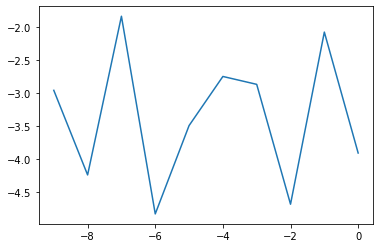

In [24]:
plt.plot(XX, YY)
plt.show()